In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c anaconda beautifulsoup4 --yes
!conda install lxml --yes
import requests
from bs4 import BeautifulSoup
import lxml
import json
from math import sin, cos, sqrt, atan2, radians

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         237 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0        conda-forge
    geopy:         1.20.0-py_0      conda-forge

The following pac

Introduction

Harry is thinking about opening a Pizza cuisine. He is currently considering 2 options between New York, where he can stay close to his old mom, and Toronto, his spouse's hometown. To make a decision, he ask me to get some figure about the competitors in 2 areas. This analysis will help guide Harry on how many competitors will be around if he decides to run his own Pizza shop.

Data Collection and Usage

In this assignment we will collect the venues around the cities from Foursquare service. Then we will find the cities where there is less number of cuisine business to derive the potential prospect.

Define account credential to retrieve data from Foursquare

In [2]:
CLIENT_ID = 'QJRGPIGUGTJ5DWZKPESXSFCMTDOIDBWF4RTCF0WHSNWV2NL3' # your Foursquare ID
CLIENT_SECRET = 'BUM2WUONMARC11MG2T3MWHVN3DGG5KKXTTLFNSBS1AICWVUV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QJRGPIGUGTJ5DWZKPESXSFCMTDOIDBWF4RTCF0WHSNWV2NL3
CLIENT_SECRET:BUM2WUONMARC11MG2T3MWHVN3DGG5KKXTTLFNSBS1AICWVUV


Illustrate district location on a map

In [158]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Data downloaded!


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [5]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [6]:
# retreive response from provided page
response = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df = pd.read_html(response.text)
df_postcode = df[0]
df_postcode = df_postcode[df_postcode.Borough != 'Not assigned'] # remove row which 'Borough' is 'Not assigned'
df_postcode['Neighbourhood'].loc[df_postcode['Neighbourhood'] == 'Not assigned'] = df_postcode['Borough'] # copy 'Borough' value to 'Neighbourhood' column for 'Neighbourhood' whose value is 'Not assigned'
df_postcode = df_postcode.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x)).reset_index() # group row with same 'Postcode' and 'Borough' and join 'Neighborhood' with ',' and reset index of dataframe
df_postcode = df_postcode[['Postcode', 'Borough', 'Neighbourhood']] # pick only required columns

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
# define latitude and longitude function
def lat_lng(postcode):
    return df_lat_lng.loc[df_lat_lng['Postal Code'] == postcode]

In [9]:
# download coordinates from csv file
df_lat_lng = pd.read_csv('Geospatial_Coordinates.csv')

df_postcode[['Latitude', 'Longitude']] = lat_lng(df_postcode['Postcode'])[['Latitude', 'Longitude']]
df_TR = df_postcode[df_postcode['Borough'].str.contains('Toronto')]

In [130]:
# find average lat, long of Toronto
TR_latitude = df_TR['Latitude'].mean()
TR_longitude = df_TR['Longitude'].mean()
print('{}, {}'.format(TR_latitude, TR_longitude))
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[TR_latitude , TR_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_TR['Latitude'], df_TR['Longitude'], df_TR['Borough'], df_TR['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

43.667262184210514, -79.38988323421053


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category','Venue Cat id']
    
    print('Done! shape is ', nearby_venues.shape)
    return(nearby_venues)

In [14]:
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [13]:
TR_venues = getNearbyVenues(names=df_TR['Neighbourhood'],
                                   latitudes=df_TR['Latitude'],
                                   longitudes=df_TR['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

Obtain id of all restaurant categories in Foursquare from the following link

https://api.foursquare.com/v2/venues/categories

In [185]:
headers = {
    'Accept': 'application/json, text/javascript, */*; q=0.01',
    'Referer': 'https://developer.foursquare.com/docs/resources/categories',
    'Origin': 'https://developer.foursquare.com',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.132 Safari/537.36',
    'Sec-Fetch-Mode': 'cors',
}

params = (
    ('v', '20170211'),
    ('oauth_token', 'QEJ4AQPTMMNB413HGNZ5YDMJSHTOHZHMLZCAQCCLXIX41OMP'),
    ('includeSupportedCC', 'true'),
)

response = requests.get('https://api.foursquare.com/v2/venues/categories', headers=headers, params=params)
restaurant_id = list(json_normalize(json.loads(response.text)['response']['categories'][3]['categories'])['id'])
business_hub_id = list(json_normalize(json.loads(response.text)['response']['categories'][6]['categories'])['id'])

In [24]:
def check_id(checked, host):
    out = list([])
    for i in checked:
        out.append(i in host)
    return out

In [53]:
NY_competitors = newyork_venues[['Venue Category', 'Venue']].loc[check_id(newyork_venues['Venue Cat id'], restaurant_id)].groupby(['Venue Category']).count()
NY_areal = 783.8
NY_poppulation = 8.62
NY_num_restaurants = NY_competitors[['Venue']].sum()
print('There are {} restaurants in Toronto'.format(NY_num_restaurants[0]))
print('Toronto covers {} sq.km. which yield {:0.2f} restautants per sq.km.'.format(NY_areal, NY_num_restaurants[0]/TR_areal))
print('Toronto has {} million poppulation which yield {:0.3f} restautants per a thousand people'.format(NY_poppulation, NY_num_restaurants[0]/NY_poppulation/1000))

There are 4224 restaurants in Toronto
Toronto covers 783.8 sq.km. which yield 6.70 restautants per sq.km.
Toronto has 8.62 million poppulation which yield 0.490 restautants per a thousand people


In [52]:
TR_competitors = TR_venues[['Venue Category', 'Venue']].loc[check_id(TR_venues['Venue Cat id'], restaurant_id)].groupby(['Venue Category']).count()
TR_areal = 630.2
TR_poppulation = 2.93
TR_num_restaurants = TR_competitors[['Venue']].sum()
print('There are {} restaurants in Toronto'.format(TR_num_restaurants[0]))
print('Toronto covers {} sq.km. which yield {:0.2f} restautants per sq.km.'.format(TR_areal, TR_num_restaurants[0]/TR_areal))
print('Toronto has {} million poppulation which yield {:0.3f} restautants per a thousand people'.format(TR_poppulation, TR_num_restaurants[0]/TR_poppulation/1000))

There are 855 restaurants in Toronto
Toronto covers 630.2 sq.km. which yield 1.36 restautants per sq.km.
Toronto has 2.93 million poppulation which yield 0.292 restautants per a thousand people


In [164]:
battle_df = pd.DataFrame(columns = ['City', 'Areal extent', 'Population', 'No. of restaurants', 'Areal density', 'Population density'])
battle_df['City'] = ['New York', 'Toronto']
battle_df['Areal extent'] = [783.8, 630.2]
battle_df['Population'] = [8.62, 2.93]
battle_df['No. of restaurants'] = [NY_num_restaurants[0], TR_num_restaurants[0]]
battle_df['Areal density'] = [NY_num_restaurants[0]/NY_areal, TR_num_restaurants[0]/TR_areal]
battle_df['Population density'] = [NY_num_restaurants[0]/NY_poppulation/1000, TR_num_restaurants[0]/TR_poppulation/1000]
battle_df

,City,Areal extent,Population,No. of restaurants,Areal density,Population density
0,New York,783.8,8.62,4224,5.389130,0.490023
1,Toronto,630.2,2.93,855,1.356712,0.291809


To compare between the 2 cities, we normalize the number of restaurants in areal wise and population wise. From both perspectives, the density restaurants are much lower in Toronto so it is a good idea to opt the location with less number of competitors. Thus, we should deepen our analysis in Toronto. 

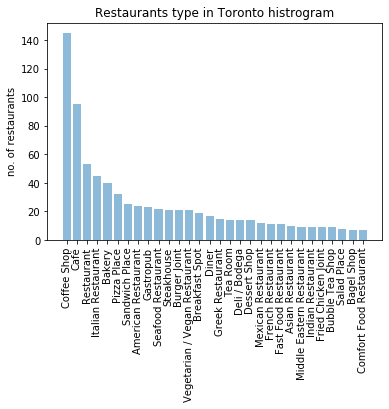

In [120]:
TR_competitors_top30 = TR_competitors.sort_values(['Venue'], ascending=False)[0:30]
y_list = list(TR_competitors_top30['Venue'])
x_label = np.array(TR_competitors_top30.index)
plt.bar(np.arange(len(y_list)), y_list, align='center', alpha=0.5)
plt.xticks(np.arange(len(y_list)), x_label, rotation='vertical')
plt.ylabel('no. of restaurants')
plt.title('Restaurants type in Toronto histrogram')

plt.show()

As observed from the chart above, Pizza and Italian restaurants looks very popular among Canadian citizens (both are in Top 5) so Harry's idea for pizza restaurant should correspond with local taste.

Then next step is to locate the area which still have not much pizza and italian restaurants.

In [157]:
# create a map displaying all pizza and Italian restaurants in Toronto
competitors = TR_venues.loc[np.logical_or(TR_venues['Venue Category']=='Pizza Place', TR_venues['Venue Category']=='Italian Restaurant')]
map_Toronto = folium.Map(location=[TR_latitude , TR_longitude], zoom_start=12)

# add Borough markers to map
for lat, lng, borough, neighborhood in zip(df_TR['Latitude'], df_TR['Longitude'], df_TR['Borough'], df_TR['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)

# add Restaurant markers to map
for lat, lng, neighborhood, venue, cat in zip(competitors['Venue Latitude'], competitors['Venue Longitude'], competitors['Neighborhood'], competitors['Venue'], competitors['Venue Category']):
    label = '{}, {} ({})'.format(venue, neighborhood, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

define function to calculate cumulative distance from borough's center to all restaurants

In [145]:
def cal_distance(la1, lo1, la2, lo2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [146]:
def distance(lat1, lng1, lat_arr, lng_arr):
    out = list([])
    for lat, lng in zip(lat1, lng1):
        sum_ = 0
        for la2, ln2 in zip(lat_arr, lng_arr):
            sum_ += cal_distance(lat, lng, la2, ln2)
        sum_ /= len(lat_arr)
        out.append(sum_)
    return out

Find the Boroughs which have the highest cumulative distance from all restaurants and choose them as potential prospects

In [165]:
df_TR['avg_distance']=distance(df_TR['Latitude'], df_TR['Longitude'], competitors['Venue Latitude'], competitors['Venue Longitude'])
df_TR[['Borough', 'Neighbourhood', 'avg_distance']].sort_values(['avg_distance'], ascending=False).reset_index(drop=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Borough,Neighbourhood,avg_distance
0,West Toronto,"Runnymede, Swansea",8.181313
1,East Toronto,The Beaches,7.982061
2,Central Toronto,Lawrence Park,7.854229
3,Central Toronto,North Toronto West,6.741902
4,West Toronto,"High Park, The Junction South",6.737196
5,Central Toronto,Roselawn,6.706040
6,Central Toronto,Davisville North,6.259602
7,West Toronto,"Parkdale, Roncesvalles",6.248296
8,East Toronto,"The Beaches West, India Bazaar",6.126213
9,East Toronto,Business Reply Mail Processing Centre 969 Eastern,5.629686


Cluster zone to observe area with smallest number of restaurants

In [133]:
# set number of clusters
kclusters = 5

TR_grouped_clustering = competitors[['Venue Latitude','Venue Longitude']]

# run k-means clustering
TR_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(TR_grouped_clustering)
competitors['cluster_label'] = TR_kmeans.labels_
TR_kmeans.labels_

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0,
       4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 3], dtype=int32)

In [154]:
competitors[['Venue', 'cluster_label']].groupby('cluster_label').count()

,Venue
cluster_label,
0,45
1,5
2,8
3,9
4,10


Discussion

To optimize the location for the restaurant, select cluster zone 1 which has the lowest number of competitors and gain the highest number of potential customers.

In [156]:
competitors.loc[competitors['cluster_label'] == 1].reset_index(drop=True)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Cat id,cluster_label
0,"High Park, The Junction South",43.661608,-79.464763,nodo,43.665303,-79.465621,Italian Restaurant,4bf58dd8d48988d110941735,1
1,"Parkdale, Roncesvalles",43.648960,-79.456325,Domani Restaurant & Wine Bar,43.649235,-79.450229,Italian Restaurant,4bf58dd8d48988d110941735,1
2,"Runnymede, Swansea",43.651571,-79.484450,Campo,43.655191,-79.487067,Italian Restaurant,4bf58dd8d48988d110941735,1
3,"Runnymede, Swansea",43.651571,-79.484450,Goodfellas Wood Oven Pizza,43.648224,-79.486356,Italian Restaurant,4bf58dd8d48988d110941735,1
4,"Runnymede, Swansea",43.651571,-79.484450,Classico,43.649194,-79.484699,Pizza Place,4bf58dd8d48988d1ca941735,1


Conclusion

Potential locations to run a new pizza business are in High Park, The Junction South, Parkdale, Roncesvalles, Runnymede and Swansea areas.